<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [69]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [70]:
"""class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y"""

'class Data(Dataset):\n    def __init__(self, dataset):\n        super(Data, self).__init__()\n\n        self.dataset = dataset\n\n    def __len__(self):\n        return len(self.dataset)\n\n    def __getitem__(self, idx):\n        x = self.dataset.data[idx]\n        y = self.dataset.targets[idx]\n        return x, y'

In [71]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow,forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)
        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [72]:
def rescale(x, lo, hi):
    """Rescale a tensor to [lo,hi]."""
    assert(lo < hi), "[rescale] lo={0} must be smaller than hi={1}".format(lo,hi)
    old_width = torch.max(x)-torch.min(x)
    old_center = torch.min(x) + (old_width / 2.)
    new_width = float(hi-lo)
    new_center = lo + (new_width / 2.)
    # shift everything back to zero:
    x = x - old_center
    # rescale to correct width:
    x = x * (new_width / old_width)
    # shift everything to the new center:
    x = x + new_center
    # return:
    return x

In [73]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

X_train = train_image.data.type(dtype=torch.float32)
y_train = train_image.targets

X_test = test_image.data.type(dtype=torch.float32)
y_test = test_image.targets

# Dequantization
uniform = torch.distributions.uniform.Uniform(torch.tensor([-0.5]), torch.tensor([0.5]))

X_train = torch.tensor(X_train) + uniform.sample(X_train.shape).squeeze()
X_train = rescale(X_train, 0., 1.).numpy()

X_test = torch.tensor(X_test)+ uniform.sample(X_test.shape).squeeze()
X_test = rescale(X_test, 0., 1.).numpy()

<ipython-input-73-2bf555d63314>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train) + uniform.sample(X_train.shape).squeeze()
<ipython-input-73-2bf555d63314>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)+ uniform.sample(X_test.shape).squeeze()


In [74]:
train_data = Data(X_train)
test_data = Data(X_test)

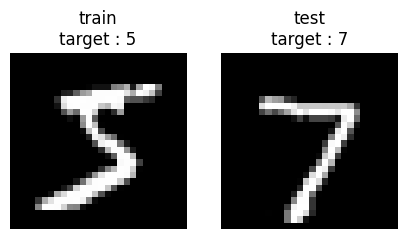

In [75]:
image_train = train_data[0]
category_train = y_train[0]
image_test = test_data[0]
category_test = y_test[0]

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [76]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=512, num_flows=10)

train_loader = DataLoader(train_data, batch_size=5000, shuffle=True)


In [77]:
epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1106.9191996256511
Epoch :  2   -----------> Loss :  1076.9982096354167
Epoch :  3   -----------> Loss :  1047.836446126302
Epoch :  4   -----------> Loss :  1018.8868408203125
Epoch :  5   -----------> Loss :  990.4835968017578
Epoch :  6   -----------> Loss :  962.4368336995443
Epoch :  7   -----------> Loss :  934.4670918782552
Epoch :  8   -----------> Loss :  906.7183074951172
Epoch :  9   -----------> Loss :  878.6989898681641
Epoch :  10   -----------> Loss :  851.1366678873698
Epoch :  11   -----------> Loss :  823.3165537516276
Epoch :  12   -----------> Loss :  795.6844635009766
Epoch :  13   -----------> Loss :  768.3495076497396
Epoch :  14   -----------> Loss :  740.6522623697916
Epoch :  15   -----------> Loss :  713.4246063232422
Epoch :  16   -----------> Loss :  686.2158762613932
Epoch :  17   -----------> Loss :  658.8372395833334
Epoch :  18   -----------> Loss :  631.5706837972006
Epoch :  19   -----------> Loss :  604.8424530029297

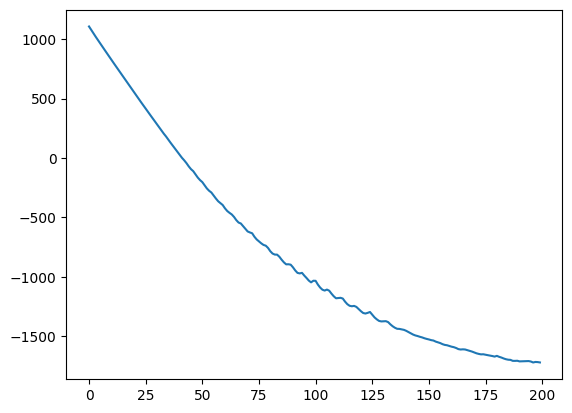

In [78]:
plt.plot(COST)

In [79]:
test = prior.sample((50,))
test

tensor([[-0.6449,  2.8130, -0.1249,  ..., -0.5365, -1.0132,  0.3253],
        [-1.0861,  1.4134,  0.2314,  ..., -1.5847,  1.6243,  0.3304],
        [ 0.2125, -0.2164,  1.7189,  ...,  0.3008, -0.0235,  0.5422],
        ...,
        [-0.0918,  1.0173, -0.6008,  ...,  0.2867,  0.6256, -2.0920],
        [-0.3926,  0.4355,  1.6451,  ..., -0.6221,  0.0959,  0.5741],
        [-1.2965, -0.8582,  0.6031,  ...,  0.3074, -0.8881, -1.9204]])

In [80]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 3.6226e-03,  2.3924e-03,  1.1746e-03,  ...,  1.6881e-03,
          1.2203e-03,  7.0996e-04],
        [ 3.3240e-04, -1.7751e-03,  1.9576e-03,  ...,  1.4365e-03,
          3.7676e-03,  2.3339e-03],
        [ 2.4502e-03,  4.4906e-03,  1.3857e-03,  ..., -8.4609e-04,
         -2.9234e-04,  2.5212e-03],
        ...,
        [ 4.4635e-03,  6.7997e-05,  3.9727e-03,  ...,  2.4443e-03,
          5.2197e-04,  4.2901e-03],
        [ 3.1982e-03,  2.0094e-04,  1.8171e-04,  ...,  2.7756e-03,
         -7.4282e-04,  5.1714e-03],
        [ 1.7124e-03,  9.6005e-04, -1.9643e-04,  ..., -6.3847e-04,
          4.3031e-03,  8.4707e-04]], grad_fn=<MulBackward0>)

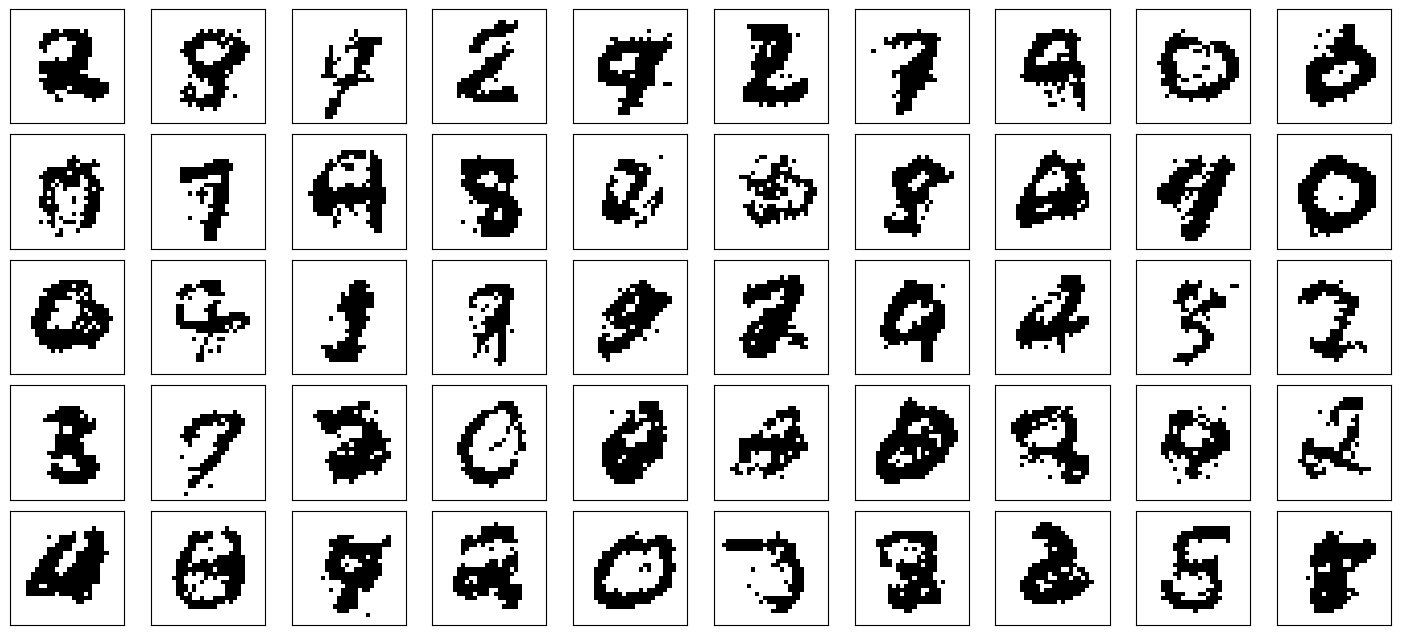

In [81]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>0.3] = 1
sonuc[sonuc[:]<=0.3] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

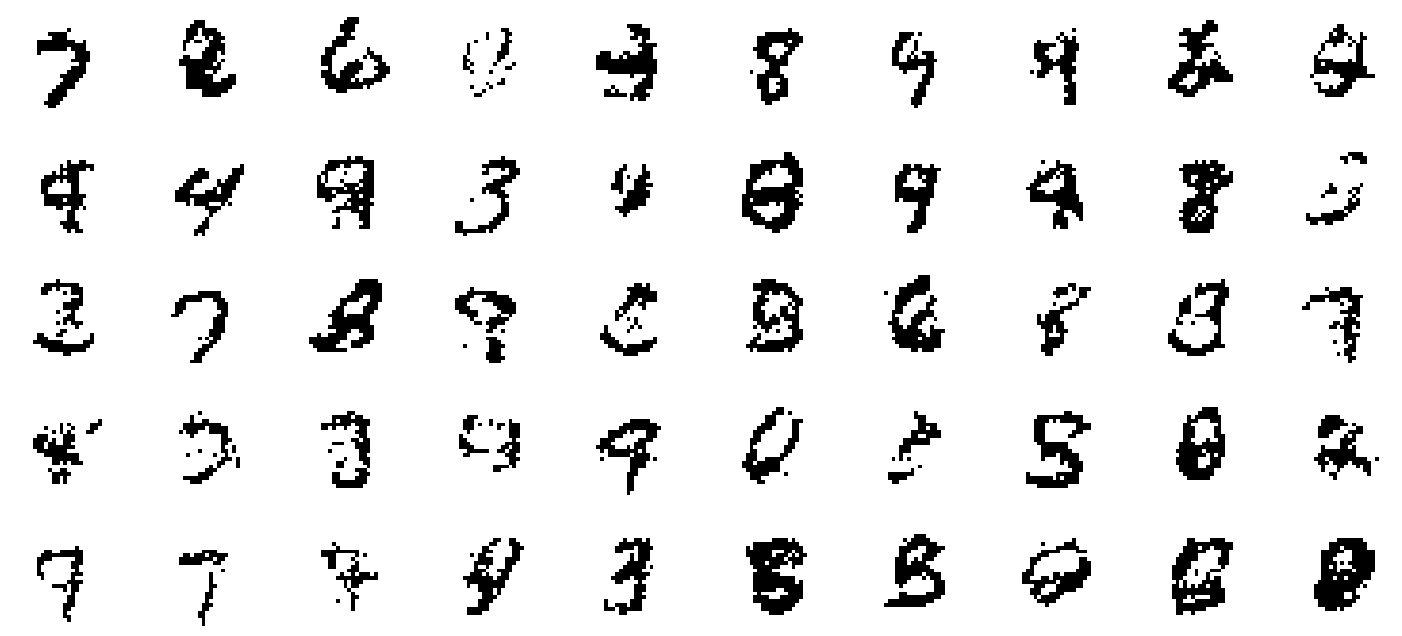

In [82]:
test = prior.sample((50,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>0.4] = 1
sonuc[sonuc[:]<=0.4] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
    axs[3, i].axis('off')
    axs[4, i].axis('off')
fig.show()

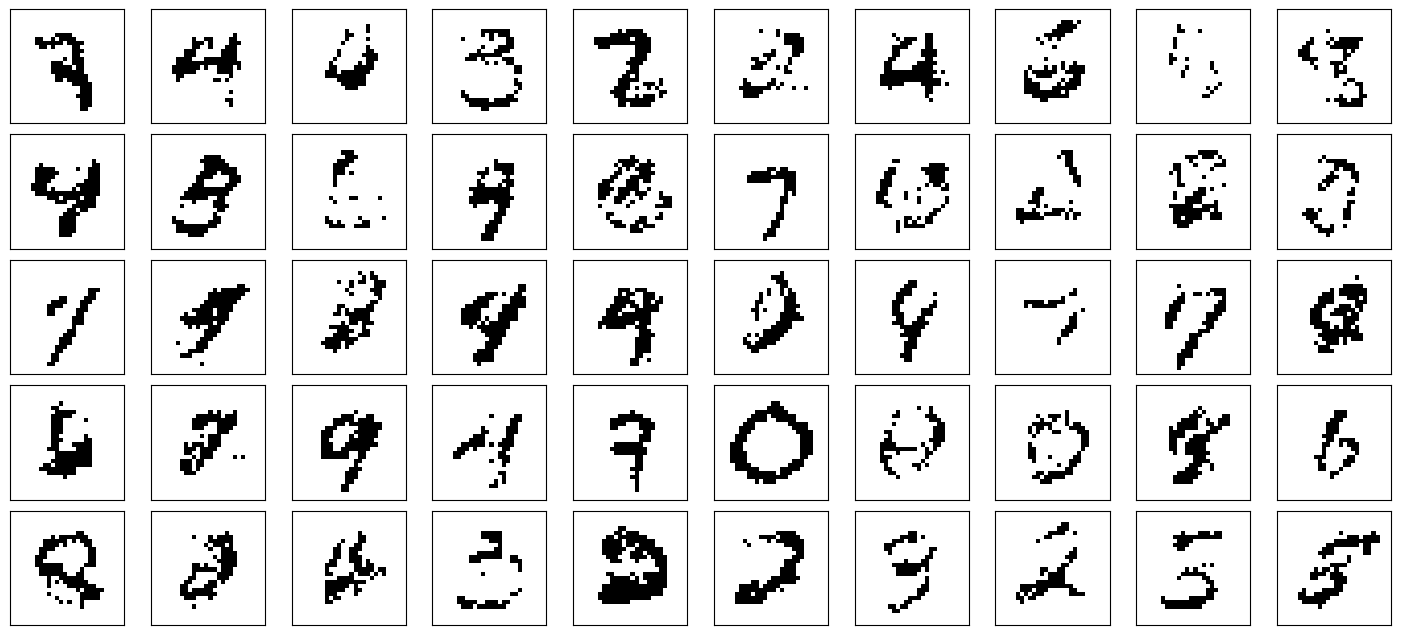

In [83]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)

sonuc[sonuc[:]>=0.5] = 1
sonuc[sonuc[:]<0.5] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

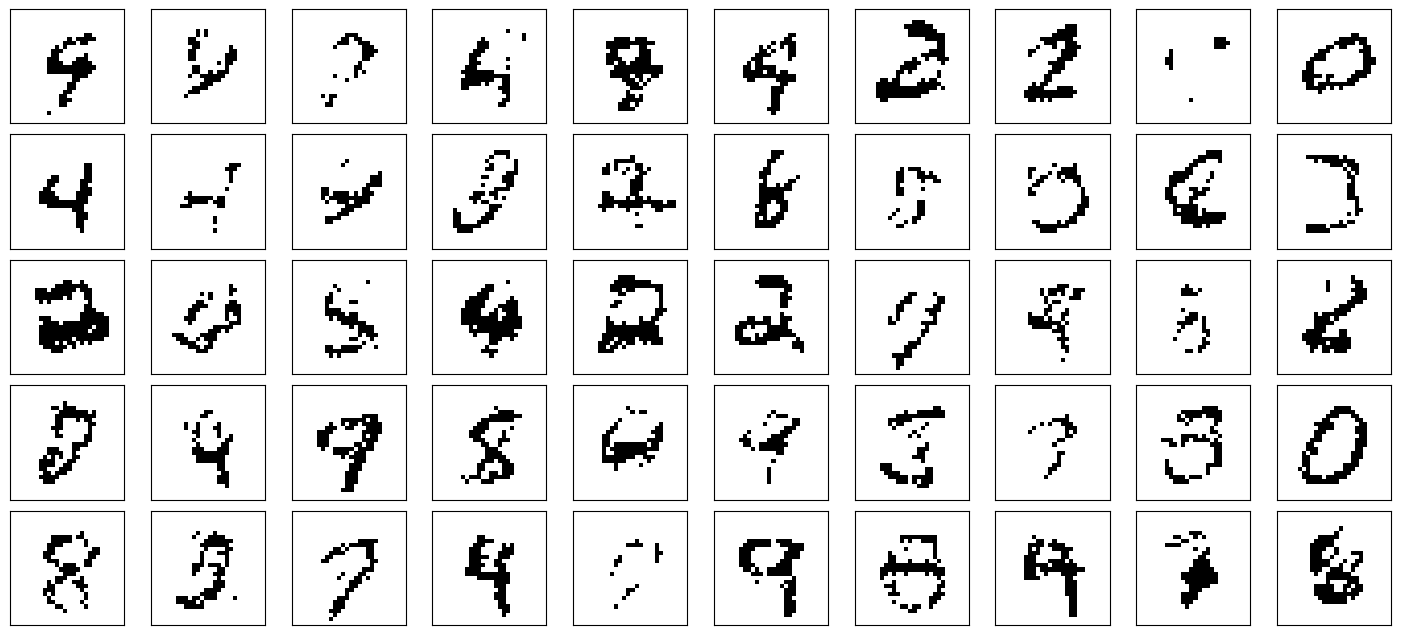

In [84]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>0.6] = 1
sonuc[sonuc[:]<=0.6] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

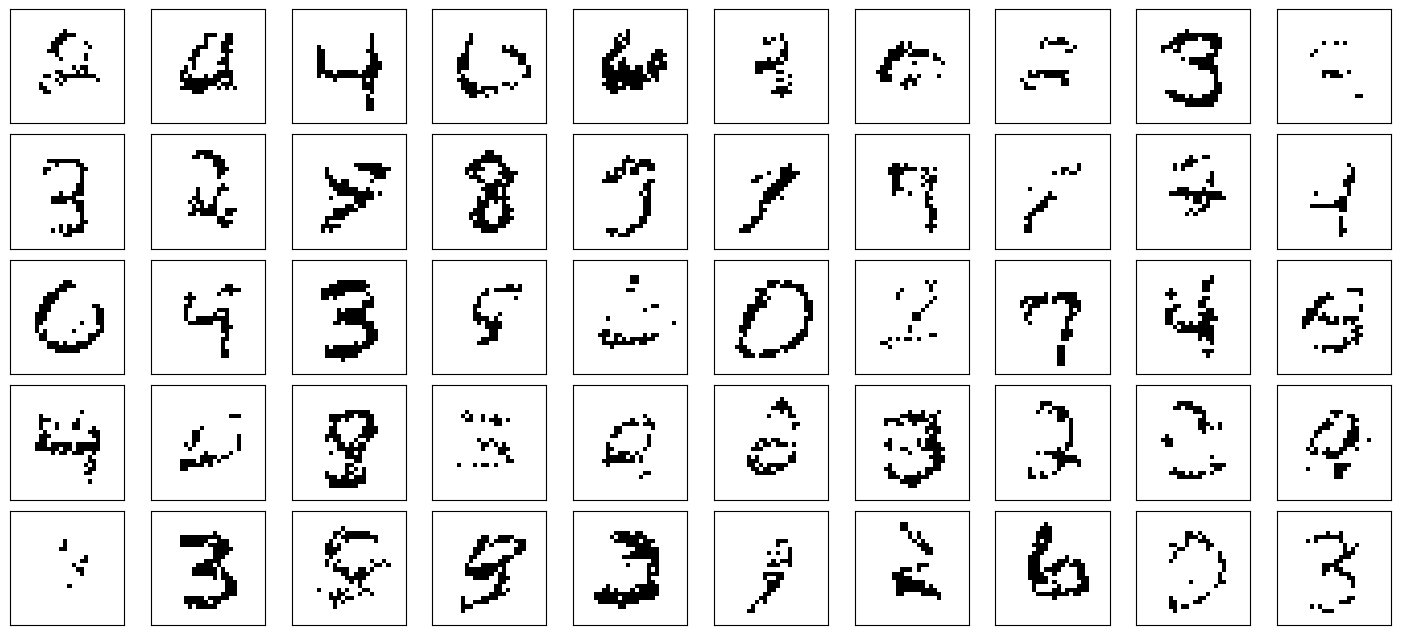

In [85]:
test = prior.sample((1797,))
sonuc = (model.f_inv(test))
sonuc[sonuc[:]>0.7] = 1
sonuc[sonuc[:]<=0.7] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()

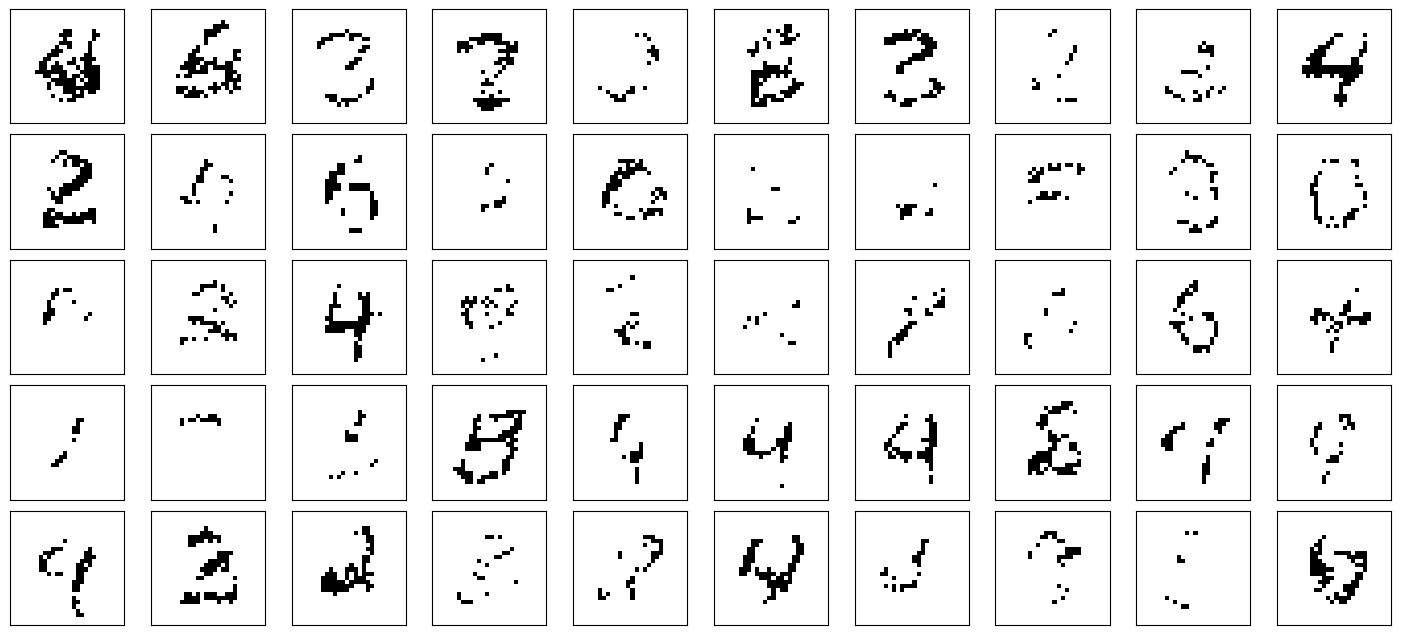

In [86]:
test = prior.sample((1797,))
sonuc = (model.f_inv(test))
sonuc[sonuc[:]>0.8] = 1
sonuc[sonuc[:]<=0.8] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
fig.show()